# Projet ML Classification

On cherche à vcomparer les performances de plusieurs méthodes de classification, dans le cas de Machine learning.

Pour ce travail, on cherchera à évaluer si une personne est dite riche ou pauvre, des données booléennes configurée arbitrairement par moi-même.

Classifieurs utilisés :
    -AdaBoostClassifier
    -BaggingClassifier
    -SupportVectorMachine (SVM)
    -SGDClassifier

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### Base de donnée

La base de donnée choisir contient plusieurs informations importantes dans la déduction du salaire d'une personne, comme son âge ou bien encore son niveau d'étude. 

In [5]:
income = pd.read_csv(r'..\data\adult.csv')
income.head()
print(income.head())
income.shape

   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States

(32561, 15)

On choisit de remplacer les données manquantes par des NaN.

In [6]:
income[income == '?'] = np.nan
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Pré-traitement de la base de donnée

Nous allons enlever une colonne qui ne va pas nous servir pour ce que nous cherchons à prédire, c'est à dire la colle fnlwgt, colonne qui attribue un numéro aléatoire pour chaque personne de la base de donnée. 

In [7]:
income = income.drop([ 'fnlwgt'], axis=1)

income.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Puis, pour que l'étude soit plus facile, nous allons transformer les valeurs de la colonne income (jusque là en string) en variable de type booléenne. Ainsi, une personne ayant un salaire de plus de 50 000$ par an (soir riche) sera notée comme 1, les "pauvres" seront notées comme 0.

In [8]:
income['income'] = income['income'].apply(lambda x: 0 if x.strip() == '<=50K' else 1)

print(income['income'].value_counts())
#print(income.head())

income
0    24720
1     7841
Name: count, dtype: int64


On peut voir que l'on a une trop grande disparité entre les pauvres et les riches pour avoir des résultats pertinents.
Pour réequilibrer la colonne income, nous allons faire du sous-échantillonage de la colonne, 

In [9]:
moins_50k = income[income['income'] == 0 ]
plus_50k = income[income['income'] == 1 ]
moins_50k_echan = moins_50k.sample(len(plus_50k), random_state=42)

income = pd.concat([moins_50k_echan, plus_50k], axis = 0)
income = income.sample(frac = 1, random_state=42).reset_index(drop = True)
print(income['income'].value_counts())
income.info()

income
1    7841
0    7841
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15682 entries, 0 to 15681
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15682 non-null  int64 
 1   workclass       14979 non-null  object
 2   education       15682 non-null  object
 3   education.num   15682 non-null  int64 
 4   marital.status  15682 non-null  object
 5   occupation      14976 non-null  object
 6   relationship    15682 non-null  object
 7   race            15682 non-null  object
 8   sex             15682 non-null  object
 9   capital.gain    15682 non-null  int64 
 10  capital.loss    15682 non-null  int64 
 11  hours.per.week  15682 non-null  int64 
 12  native.country  15409 non-null  object
 13  income          15682 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


In [10]:
income_features = ['age', 'workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

label_encoders = {}

for col in income_features:
    le = LabelEncoder()
    income[col] = le.fit_transform(income[col])
    label_encoders[col] = le

## Normalisation des données

In [11]:
scaler = MinMaxScaler()
income[income_features] = scaler.fit_transform(income[income_features])

print(income.head())

        age  workclass  education  education.num  marital.status  occupation  \
0  0.333333      0.000   0.800000             14        0.666667    0.214286   
1  0.492754      0.375   0.733333              9        0.000000    0.000000   
2  0.144928      0.375   0.600000             13        0.666667    0.642857   
3  0.217391      0.375   0.600000             13        0.333333    0.214286   
4  0.434783      0.125   0.800000             14        0.333333    0.642857   

   relationship  race  sex  capital.gain  capital.loss  hours.per.week  \
0           0.2   1.0  0.0          0.88           0.0        0.609195   
1           0.2   1.0  0.0          0.00           0.0        0.436782   
2           0.2   1.0  0.0          0.00           0.0        0.609195   
3           0.0   1.0  1.0          0.77           0.0        0.494253   
4           0.0   1.0  1.0          0.00           0.0        0.666667   

   native.country  income  
0           0.925       1  
1           0.925 

## Affichage de la matrice de corrélation

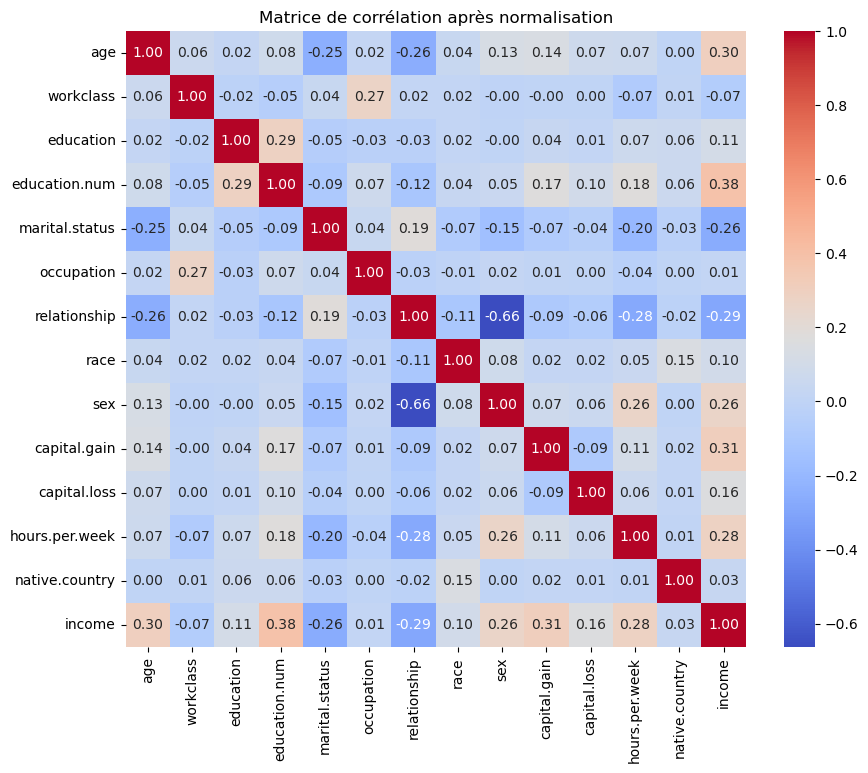

In [12]:
matrice = income.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matrice, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation après normalisation')
plt.show()

Rappel : Interprétation
    Corrélation proche de +1 : forte relation positive (si une variable augmente, l'autre aussi).
    Corrélation proche de -1 : forte relation négative (si une augmente, l'autre diminue).
    Corrélation proche de 0 : pas ou très peu de relation linéaire.

Parmi les corrélations les plus significatives avec income, on retrouve :
- education.num (corrélation de 0.38) : le niveau d'éducation est positivement associé au revenu, ce qui est cohérent avec l’idée que les individus plus diplômés ont tendance à gagner davantage.
- capital.gain (0.31) : les gains en capital sont fortement liés à un revenu supérieur.
- age (0.30) : les revenus ont tendance à augmenter avec l’âge, probablement en lien avec l’expérience professionnelle.
- hours.per.week (0.28) : plus une personne travaille d’heures par semaine, plus elle a de chances d’avoir un revenu élevé.
- capital.loss (0.16) : bien que la corrélation soit plus faible, elle suggère que les pertes en capital peuvent aussi refléter un profil de revenu particulier.
- relationship (-0.29) et marital.status (-0.26) : certaines situations familiales ou maritales sont inversement associées aux revenus élevés (par exemple, être célibataire ou chef de famille sans partenaire).

C'est probablement les features que nous allons choisir pour nos modèles.

## Visualisation des outliers

In [13]:
categorical_cols = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
numerical_cols = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

print(income)

            age  workclass  education  education.num  marital.status  \
0      0.333333      0.000   0.800000             14        0.666667   
1      0.492754      0.375   0.733333              9        0.000000   
2      0.144928      0.375   0.600000             13        0.666667   
3      0.217391      0.375   0.600000             13        0.333333   
4      0.434783      0.125   0.800000             14        0.333333   
...         ...        ...        ...            ...             ...   
15677  0.362319      0.375   0.733333              9        0.000000   
15678  0.289855      0.625   0.600000             13        0.333333   
15679  0.275362      0.500   0.733333              9        0.666667   
15680  0.101449      0.750   1.000000             10        0.666667   
15681  0.246377      0.375   0.733333              9        0.666667   

       occupation  relationship  race  sex  capital.gain  capital.loss  \
0        0.214286           0.2   1.0  0.0          0.88     

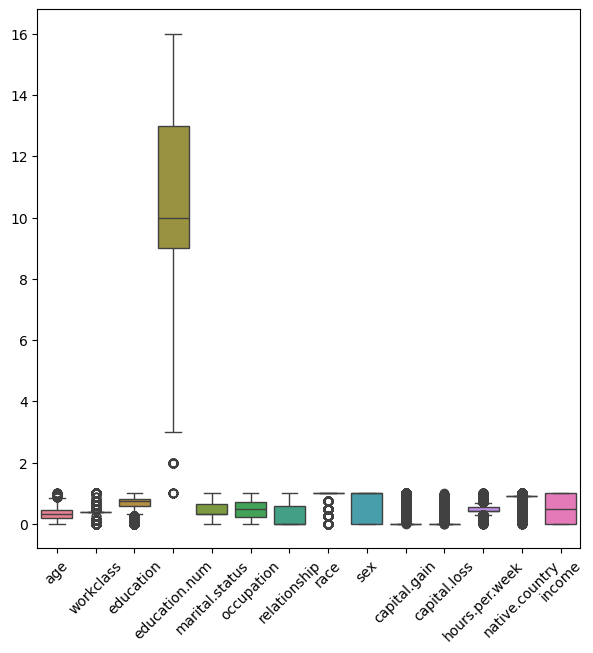

In [14]:
plt.figure(figsize=(7, 7))
sns.boxplot(data=income)
plt.xticks(rotation=45)
plt.show()

#### Analyse par variable
education.num
- Se distingue nettement avec une distribution beaucoup plus large (valeurs entre 1 et 16).
- Cela confirme son importance dans les modèles de prédiction (comme on l’a vu dans la matrice de corrélation).On voit quelques valeurs extrêmes faibles, probablement des niveaux d’études très bas

Variables comme capital.gain, capital.loss
- Très compactes avec beaucoup de valeurs nulles ou proches de zéro.
- Les outliers sont clairement visibles, indiquant que peu d’individus déclarent des gains ou pertes en capital élevés.

hours.per.week, age
- Distribution plus étendue que d'autres variables.
- Leur variabilité pourrait être informative pour les modèles.

Variables catégorielles encodées (workclass, sex, race, etc.)
- Les boîtes sont très étroites : ces variables sont encodées en valeurs numériques discrètes, donc leur distribution semble très "compressée".
- Cela rend leur interprétation visuelle moins informative dans ce type de graphique.


Series([], dtype: int64)
            age  workclass  education  education.num  marital.status  \
0      0.333333      0.000   0.800000             14        0.666667   
26     0.304348      0.375   0.666667             16        0.333333   
32     0.289855      0.375   0.533333             11        0.333333   
33     0.434783      0.375   0.800000             14        0.333333   
40     0.521739      0.375   0.466667             12        0.333333   
...         ...        ...        ...            ...             ...   
15646  0.405797      0.625   0.600000             13        0.666667   
15647  0.565217      0.500   0.666667             16        0.333333   
15656  0.028986      1.000   1.000000             10        0.666667   
15659  0.028986      1.000   1.000000             10        0.666667   
15664  0.217391      0.375   0.733333              9        0.333333   

       occupation  relationship  race  sex  capital.gain  capital.loss  \
0        0.214286           0.2   1.

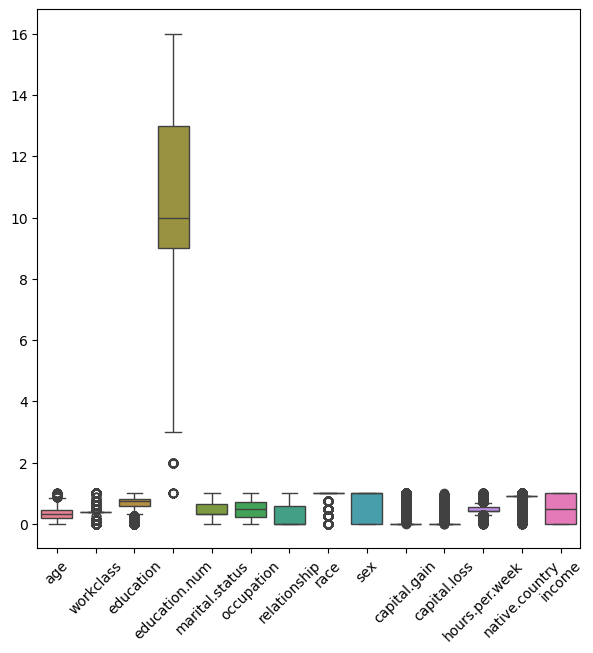

In [15]:
from scipy import stats

missing_values = income.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values)

mar = income.dropna()

mar.isnull().sum()
z_scores = stats.zscore(mar.select_dtypes(include='number'))

outliers = (z_scores > 3).sum(axis=1)
outlier_rows = mar[outliers > 0]
print(outlier_rows)

plt.figure(figsize=(7, 7))
sns.boxplot(data=mar)
plt.xticks(rotation=45)
plt.show()

#### Choix des features

On choisit donc ces 8 features pour notre études.

In [16]:
income_features = ['age', 'relationship', 'sex', 'education.num', 'marital.status', 'hours.per.week', 'capital.gain', 'capital.loss']

X = income[income_features]
X.head()

y = income['income']

#### Préparation des données de test et de train

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("shape of X : ", X.shape)
print("shape of y", y.shape)

shape of X :  (15682, 8)
shape of y (15682,)


## AdaBoost

AdaBoostClassifier - Accuracy : 0.8304
Scores pour chaque fold : [0.91158535 0.9030575  0.90633247 0.91387914 0.90180941]
Score moyen : 0.9073 (+/- 0.0047)



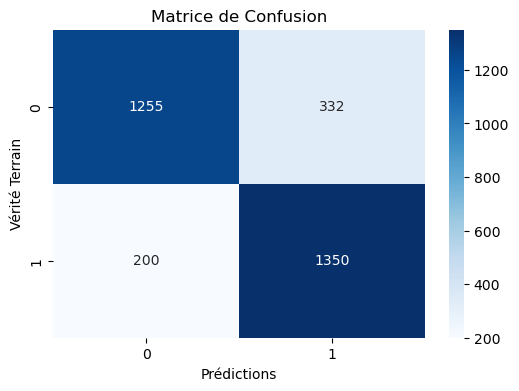

In [18]:
income_ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.7, random_state=None, algorithm='SAMME')
income_ada.fit(X_train, y_train)

y_pred_ada = income_ada.predict(X_test)
y_proba_ada = income_ada.predict_proba(X_test)[:, 1]  

income_ada.score(X_test, y_test)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
"""fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_proba_ada)
auc_score_ada = roc_auc_score(y_test, y_proba_ada)"""

print(f"AdaBoostClassifier - Accuracy : {accuracy_ada:.4f}")

cross_validation_ada = cross_val_score(income_ada, X, y, cv = 5, scoring = "average_precision")
print(f"Scores pour chaque fold : {cross_validation_ada}")
print(f"Score moyen : {np.mean(cross_validation_ada):.4f} (+/- {np.std(cross_validation_ada):.4f})\n")

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_ada, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité Terrain")
plt.show()

#### Cross-validation ADA

In [19]:
cross_validation_ada = cross_val_score(income_ada, X, y, cv = 5, scoring = 'accuracy')
print(f"Scores pour chaque fold : {cross_validation_ada}")
print(f"Score moyen : {np.mean(cross_validation_ada):.4f} (+/- {np.std(cross_validation_ada):.4f})\n")


Scores pour chaque fold : [0.82244182 0.81861651 0.82110969 0.83354592 0.82079082]
Score moyen : 0.8233 (+/- 0.0053)



Courbe ROC AdaBoost

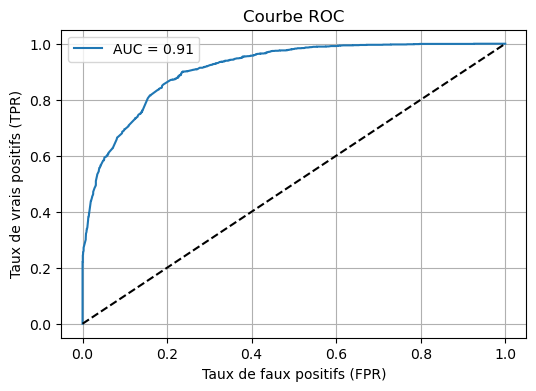

In [20]:
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_proba_ada)
auc_score_ada = roc_auc_score(y_test, y_proba_ada)

plt.figure(figsize=(6,4))
plt.plot(fpr_ada, tpr_ada, label=f"AUC = {auc_score_ada:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend()
plt.grid()
plt.show()

Le modèle AdaBoost obtient une excellente précision moyenne supérieure à 90 % en validation croisée, et se montre également très stable (écart-type faible). Ce modèle fonctionne en combinant plusieurs estimateurs faibles (généralement des arbres de décision peu profonds) et en les pondérant selon leurs performances, ce qui lui permet de corriger les erreurs des modèles précédents à chaque itération.

Pour résumer, les points forts de ce modèle sont :
- Très bon compromis biais-variance.
- Performant même sans réglages approfondis.
- Résilient aux déséquilibres modérés dans les données (ce qui est utile ici).

## Bagging

Bagging Classifier - Accuracy : 0.8081


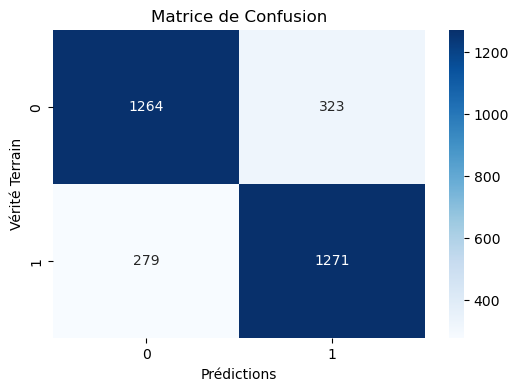

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

bag_classi = BaggingClassifier(n_estimators=300)
bag_classi.fit(X_train, y_train)

y_pred_bag = bag_classi.predict(X_test)
y_proba_bag = bag_classi.predict_proba(X_test)[:, 1]  
bag_classi.score(X_test, y_test)

accuracy_bag = accuracy_score(y_test, y_pred_bag)
conf_matrix_bag = confusion_matrix(y_test, y_pred_bag)

print(f"Bagging Classifier - Accuracy : {accuracy_bag:.4f}")


plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_bag, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité Terrain")
plt.show()

#### cross-validation bagging

In [22]:
cross_validation_bag = cross_val_score(bag_classi, X, y, cv = 5, scoring = 'accuracy')
print(f"Scores pour chaque fold : {cross_validation_bag}")
print(f"Score moyen : {np.mean(cross_validation_bag):.4f} (+/- {np.std(cross_validation_bag):.4f})\n")

Scores pour chaque fold : [0.81957284 0.80618425 0.80867347 0.8182398  0.79432398]
Score moyen : 0.8094 (+/- 0.0092)



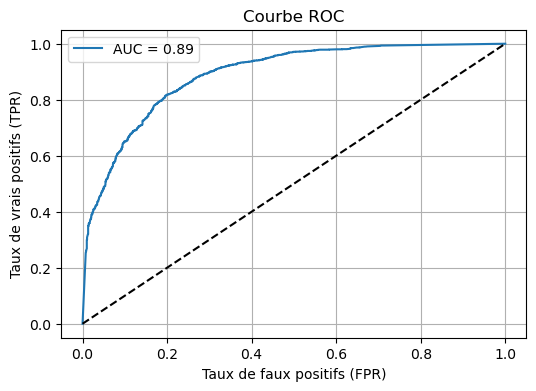

In [23]:
fpr_bag, tpr_bag, thresholds_bag = roc_curve(y_test, y_proba_bag)
auc_score_bag = roc_auc_score(y_test, y_proba_bag)

plt.figure(figsize=(6,4))
plt.plot(fpr_bag, tpr_bag, label=f"AUC = {auc_score_bag:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend()
plt.grid()
plt.show()

## Suppor Vector Machine

Accuracy: 0.763787057698438

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77      1587
           1       0.76      0.76      0.76      1550

    accuracy                           0.76      3137
   macro avg       0.76      0.76      0.76      3137
weighted avg       0.76      0.76      0.76      3137



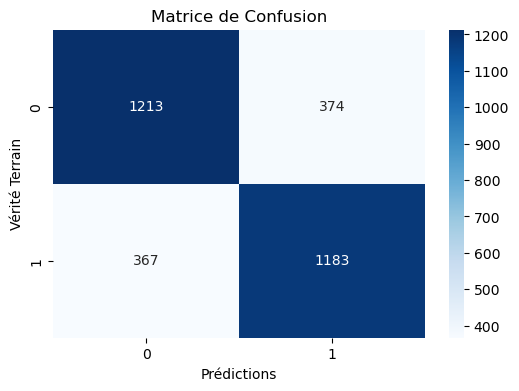

In [24]:
SVM_classi = svm.SVC(kernel = 'linear', C=1.0, probability=True)
SVM_classi.fit(X_train, y_train)
y_pred_SVM = SVM_classi.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_SVM))
print("\nClassification Report:\n", classification_report(y_test, y_pred_SVM))

conf_mat_SVM = confusion_matrix(y_test, y_pred_SVM)
y_proba_SVM = SVM_classi.predict_proba(X_test)[:, 1]  

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_SVM, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité Terrain")
plt.show()

In [25]:
cross_validation_SVM = cross_val_score(SVM_classi, X, y, cv = 5, scoring = 'accuracy')
print(f"Scores pour chaque fold : {cross_validation_SVM}")
print(f"Score moyen : {np.mean(cross_validation_SVM):.4f} (+/- {np.std(cross_validation_SVM):.4f})\n")

Scores pour chaque fold : [0.7803634  0.76569971 0.76466837 0.77774235 0.75797194]
Score moyen : 0.7693 (+/- 0.0084)



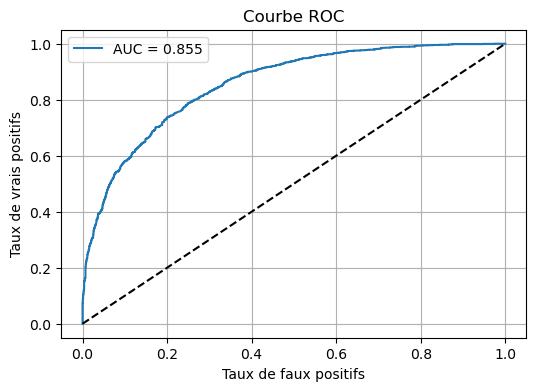

In [26]:
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(y_test, y_proba_SVM)
auc_score_SVM = roc_auc_score(y_test, y_proba_SVM)

plt.figure(figsize=(6,4))
plt.plot(fpr_SVM, tpr_SVM, label=f"AUC = {auc_score_SVM:.3f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend()
plt.grid()
plt.show()

## SGD Classifier

Accuracy: 0.7679311444054829

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77      1587
           1       0.75      0.79      0.77      1550

    accuracy                           0.77      3137
   macro avg       0.77      0.77      0.77      3137
weighted avg       0.77      0.77      0.77      3137



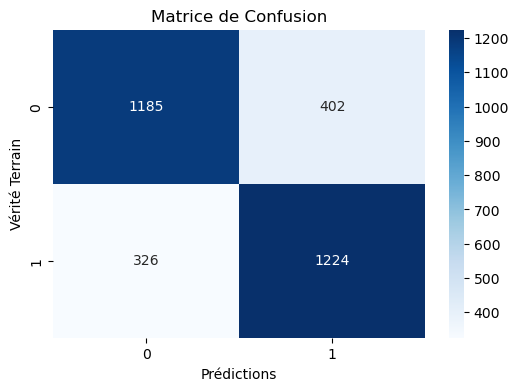

In [27]:
SGD_classifier = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3, loss='log_loss'))
SGD_classifier.fit(X_train, y_train)

y_pred_SGD = SGD_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_SGD))
print("\nClassification Report:\n", classification_report(y_test, y_pred_SGD))

conf_mat_SGD = confusion_matrix(y_test, y_pred_SGD)
y_proba_SGD = SGD_classifier.predict_proba(X_test)[:, 1]  

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_SGD, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité Terrain")
plt.show()

In [28]:
cross_validation_SGD = cross_val_score(SGD_classifier, X, y, cv = 5, scoring = 'accuracy')
print(f"Scores pour chaque fold : {cross_validation_SGD}")
print(f"Score moyen : {np.mean(cross_validation_SGD):.4f} (+/- {np.std(cross_validation_SGD):.4f})\n")

Scores pour chaque fold : [0.77526299 0.75709276 0.76020408 0.77359694 0.75350765]
Score moyen : 0.7639 (+/- 0.0088)



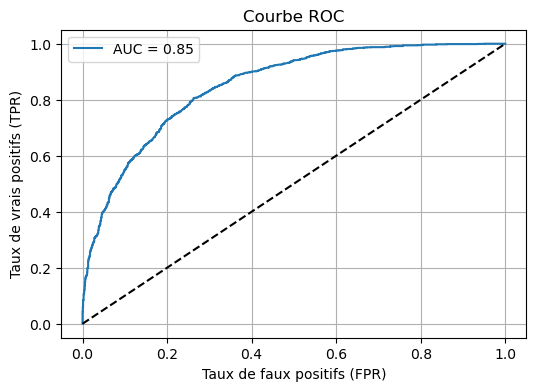

In [29]:
fpr_SGD, tpr_SGD, thresholds_SGD = roc_curve(y_test, y_proba_SGD)
auc_score_SGD = roc_auc_score(y_test, y_proba_SGD)

plt.figure(figsize=(6,4))
plt.plot(fpr_SGD, tpr_SGD, label=f"AUC = {auc_score_SGD:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.legend()
plt.grid()
plt.show()

### Conclusion de la classification

AdaBoostClassifier s’est démarqué comme le plus performant, atteignant une accuracy de 83 % sur le jeu de test et une moyenne de 91 % en validation croisée. BaggingClassifier suit avec de bonnes performances (80 %), tandis que SGDClassifier et SVM offrent des résultats plus modestes autour de 76 %.

En conclusion, AdaBoost est le modèle le plus adapté à ce jeu de données. Il combine précision, stabilité et capacité à modéliser des relations complexes. Pour améliorer davantage les résultats, il serait pertinent d’explorer le réglage d’hyperparamètres, d’essayer d’autres modèles ensemblistes comme XGBoost, ou encore d’appliquer des techniques avancées de sélection de variables.

## Nouvelles données

On va choisir de tester nos modèles avec des données choisis arbitrairement.

In [ ]:
trained_models = {
    "AdaBoost": income_ada,
    "Bagging": bag_classi,    
    "SVM": SVM_classi,
    "SGDClassifier" : SGD_classifier
}

scaler = MinMaxScaler()
scaler.fit(X_train[income_features])

def tester_tous_les_modeles(data_brute, models, scaler, label_encoders, income_features):
    import pandas as pd

    nouvelles_données = pd.DataFrame([data_brute])

    for col in nouvelles_données.columns:
        if col in label_encoders:
            encoder = label_encoders[col]
            try:
                nouvelles_données[col] = encoder.transform(nouvelles_données[col])
            except ValueError:
                print(f"⚠️ Valeur inconnue pour '{col}' : {nouvelles_données[col][0]} → remplacée par -1")
                nouvelles_données[col] = -1

    try:
        nouvelles_données = nouvelles_données[income_features]
        nouvelles_données = nouvelles_données.astype(float)
    except KeyError as e:
        print("Erreur : colonne manquante dans les données :", e)
        return

    try:
        données_normalisées = pd.DataFrame(
            scaler.transform(nouvelles_données),
            columns=income_features
        )
    except ValueError as e:
        print("Problème de normalisation :", e)
        return

    print("Résultats des modèles :\n")
    for nom, model in models.items():
        pred = model.predict(données_normalisées)[0]
        proba = model.predict_proba(données_normalisées)[0][1]
        print(f"{nom:10} → Classe : {pred} | Probabilité >50K : {proba:.2f}")

tester_tous_les_modeles(
    data_brute={
        'age': 45,
        'relationship': 'Husband',
        'sex': 'Male',
        'education.num': 13,
        'marital.status': 'Married-civ-spouse',
        'hours.per.week': 40,
        'capital.gain': 0,
        'capital.loss': 0.1
    },
    models=trained_models,
    scaler=scaler,
    label_encoders=label_encoders,
    income_features=[
        'age', 'relationship', 'sex', 'education.num',
        'marital.status', 'hours.per.week', 'capital.gain', 'capital.loss'
    ]
)



🔎 Résultats des modèles :

AdaBoost   → Classe : 0 | Probabilité >50K : 0.44
Bagging    → Classe : 0 | Probabilité >50K : 0.07
SVM        → Classe : 1 | Probabilité >50K : 1.00
SGDClassifier → Classe : 1 | Probabilité >50K : 1.00


Nous avons testé plusieurs modèles de machine learning sur une même entrée représentant un individu, afin de prédire s’il gagne plus ou moins de 50K dollars par an. Voici les résultats obtenus :
| Modèle        | Classe prédite | Probabilité >50K |
| ------------- | -------------- | ---------------- |
| AdaBoost      | 0 (≤50K)       | 0.44             |
| SVM           | 1 (>50K)       | 1.00             |
| Bagging       | 0 (≤50K)       | 0.06             |
| SGDClassifier | 1 (>50K)       | 1.00             |

SVM et SGDClassifier prédisent que l’individu gagne plus de 50K, avec une très forte certitude (100%). Cela signifie que, pour ces modèles, les caractéristiques de la personne sont très représentatives de profils à revenu élevé.

AdaBoost, quant à lui, donne une prédiction différente. Il classe l’individu dans la catégorie ≤50K, mais avec une probabilité de 44% seulement pour >50K, ce qui révèle une grande incertitude. Le modèle est proche de la frontière de décision.

Bagging est plus tranché, et classe l’individu comme gagnant ≤50K, avec une très faible probabilité (6%) d'appartenir à la classe >50K. Cela montre qu’il est beaucoup plus conservateur que les autres modèles.

Les modèles ne sont pas tous d’accord :

- Deux modèles sont sûrs que le revenu est >50K (SVM, SGDClassifier),
- Deux modèles penchent pour ≤50K, dont un avec faible confiance (AdaBoost).

Cela met en évidence l’intérêt de comparer plusieurs modèles, et suggère que dans des cas limites ou proches de la frontière, les modèles peuvent diverger.
